# ADHS18 Example

This is the Mars exploration-inspired example that appeared in the following paper:

Sofie Haesaert, Petter Nilsson, Cristian-Ioan Vasile, Rohan Thakker, Ali-akbar Agha-Mohammadi, Aaron D. Ames and Richard M. Murray, **Temporal Logic Control of POMDPs via Label-based Stochastic Simulation Relations**, in *Proceedings of the IFAC Conference on Analysis and Design of Hybrid Systems*, 2018

**Note**: parts of the code have been updated and improved since the time of submission. Therefore, results identical to the ones that appear in the paper can not be expected due to differences in numerics and randomness. To reproduce exact results, see this [release](https://github.com/pettni/pdf-abstraction/tree/v0.0.1).

In [1]:
import polytope as pc
import numpy as np
import math
from collections import OrderedDict

import matplotlib.patches
import matplotlib.pyplot as plt
from matplotlib import patches

from best.models.lti import LTI, LTIGaussian
from best.models.pomdp import POMDP, POMDPNetwork
from best.abstraction.gridding import LTIAbstraction

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


### System dynamics

In [2]:
# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2)  #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[.4,-0.2],[-0.2,0.4]])  
# noise on state transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])
# defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None

# Sensor noise => pomdp
H = np.eye(2) #np.ones((1,2)) # what can be measured
V = 1*np.eye(2)
    #  x^+= A x + Bu + w
    #  y = C x
    #  z = H x+v

P = np.eye(2)
mean = np.zeros((2,1))
pomdp = LTIGaussian(sys_lti, H, V, P, mean)

L, Pst = pomdp.kalman()
print(Pst)
belief_mdp = pomdp.beliefmodel()

# LTI system over-approximating belief
P_init = Pst-np.eye(2)*.1
P_l =Pst-np.eye(2)*.1
P_upper =Pst #+np.eye(2)*.1

lti_belief, Error_noise,error_rank = belief_mdp.to_LTI_approx(C, P_init, P_l,P_upper, combined =False)

# Define spaces
lti_belief.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]])))) # continuous set of inputs
lti_belief.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space

print (Error_noise, error_rank)

[[ 0.84446 -0.2862 ]
 [-0.2862   0.84446]]
P_l is a valid lower bound
P_up is a valid upper bound
(0.08010882788459806, 0.17189243466963683) (2, 2)


### Regions and map MDP

In [3]:
# Define regions of interest for the labeling
regions = OrderedDict()
regions['target1'] = pc.box2poly(np.array([[-9, -6], [6, 9]]))
regions['target2'] = pc.box2poly(np.array([[6, 9], [6, 9]]))
regions['obstacle1'] = pc.box2poly(np.array([[0, 2], [-5, 2]]))
regions['obstacle2'] = pc.box2poly(np.array([[0, 2], [3, 10]]))

regions['target1meas'] = pc.box2poly(np.array([[-10, -3.9], [4.1, 10]]))
regions['target2meas'] = pc.box2poly(np.array([[4.1, 10], [4.1, 10]]))
regions['obstacle1meas'] = pc.box2poly(np.array([[-1.9, 3.9], [-6.9, 3.1]]))
regions['obstacle2meas'] = pc.box2poly(np.array([[-1.9, 3.9], [1.1, 10]]))

target_output = lambda n: ['init', 'true', 'false'][n]
    
# label prior probabilities
p_list = [0.5, 0.6, 0.1, 0.3]

map_mdp_list = [POMDP([np.eye(3), np.array([[0,p,1-p], [0,1,0], [0,0,1]])], 
                      input_names=['meas{}'.format(i)],
                      output_transform=target_output,
                      state_name='label{}'.format(i))
                      for (i, p) in enumerate(p_list)]

### Abstract dynamics

status: optimal
optimal epsilon 1.0000149374667198
optimal M [[ 1. -0.]
 [-0.  1.]]
Optimal K [[ 0.7071 -0.    ]
 [-0.     -0.7071]]
MDP: (9,) inputs ('u_d',) --> 1629 states s --> 1629 outputs (s,xc)
before prune: nnz: 9174323, sparsity: 0.3841398373865275
after prune: nnz: 808007, sparsity: 0.03383221602151744


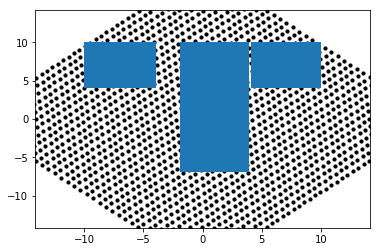

In [4]:
# simulation relation parameters
d = np.array([ 0.76481, 0.64426])
eps_min = 0.935780510323
M_min = np.array([[ 1.02097, -0.01268],
                  [-0.01268,  1.00766]])
K_min = np.array([[ 0.66149, -0.67953],
                  [-0.69586, -0.7139 ]])
delta = 0.01

abstr = LTIAbstraction(lti_belief, d, un=3)

abstr.eps = eps_min
abstr.M = M_min
abstr.K = K_min

fig = plt.figure()
ax0 = fig.add_subplot(111)
abstr.plot(ax0)

# plot regions
for _, poly in regions.items():
    V = pc.extreme(poly)
    ax0.add_patch(patches.Polygon(V))
    
print (abstr.mdp)
print ('before prune: nnz: {}, sparsity: {}'.format(abstr.mdp.nnz, abstr.mdp.sparsity))
abstr.mdp.prune(1e-6)
print ('after prune: nnz: {}, sparsity: {}'.format(abstr.mdp.nnz, abstr.mdp.sparsity))

### Plot an example transition distribution

showing transitions from [0 0] with input [-1. -1.]


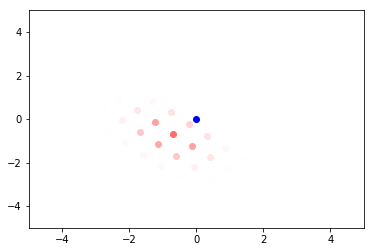

In [5]:
x0 = np.array([0,0])
ud = 0
u = abstr.ud_to_u(ud) 

print('showing transitions from {} with input {}'.format(x0, u))

Ts = np.squeeze(np.asarray(abstr.mdp.T((0,)).todense()[abstr.x_to_s(x0),:]))

for s in range(len(Ts)-1):
    x = abstr.s_to_x(s)
    plt.plot(x[0], x[1], 'o', color=(1, 1-3*Ts[s], 1-3*Ts[s]))
    
plt.plot(x0[0], x0[1], 'o', color=(0, 0, 1))
plt.xlim([-5,5])
plt.ylim([-5,5])

plt.show()

### Construct product system

MDP network: (9,) inputs ('u_d',), (1629, 3, 3, 3, 3) states ('s', 'label0', 'label1', 'label2', 'label3'), (1629, 3, 3, 3, 3) outputs ('(s,xc)', 'label0', 'label1', 'label2', 'label3')


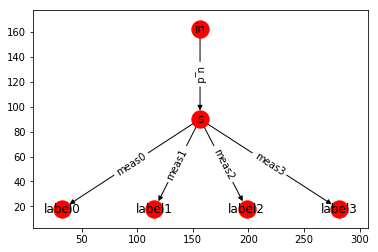

In [6]:
from best.logic.translate import *

network = POMDPNetwork([abstr.mdp] + map_mdp_list)
        
network.add_connection(['(s,xc)'], 'meas0', lambda s_xc: abstr.polytopic_predicate(s_xc[1], regions['target1meas']) )
network.add_connection(['(s,xc)'], 'meas1', lambda s_xc: abstr.polytopic_predicate(s_xc[1], regions['target2meas']) )
network.add_connection(['(s,xc)'], 'meas2', lambda s_xc: abstr.polytopic_predicate(s_xc[1], regions['obstacle1meas']) )
network.add_connection(['(s,xc)'], 'meas3', lambda s_xc: abstr.polytopic_predicate(s_xc[1], regions['obstacle2meas']) )

network.plot()
print(network)

### Set up and solve LTL problem

In [7]:
from best.solvers.valiter import solve_ltl_cosafe

def sample_predicate(s_xc, lbl_sam1, lbl_sam2):
    
    if s_xc[1] is None or np.any(s_xc[1] > 10):
        return set([0])
    
    cond1 = (True in abstr.polytopic_predicate(s_xc[1], regions['target1'])) and lbl_sam1 == 'true'
    cond2 = (True in abstr.polytopic_predicate(s_xc[1], regions['target2'])) and lbl_sam2 == 'true'
    
    return set([cond1 or cond2])

def fail_predicate(s_xc, lbl_obs1, lbl_obs2):

    if s_xc[1] is None or np.any(s_xc[1] > 10):
        return set([1])
    
    s = s_xc[0]
    cond1 = (True in abstr.polytopic_predicate(s_xc[1], regions['obstacle1'])) and lbl_obs1 == 'true'
    cond2 = (True in abstr.polytopic_predicate(s_xc[1], regions['obstacle2'])) and lbl_obs2 == 'true'
    
    return set([cond1 or cond2])
    
# LTL formula
formula = '! fail U sample'

# Define atomic propositions
predicates = [(['(s,xc)', 'label0', 'label1'], 'sample', sample_predicate),
              (['(s,xc)', 'label2', 'label3'], 'fail', fail_predicate)]

pol = solve_ltl_cosafe(network, formula, predicates, delta=delta)

finished after 12.480730295181274s and 77 iterations


### Define abstraction policy

In [8]:
# define a policy on top of mdp policy
def my_policy(x, mapstate):
    # x: current concrete state [x; y]
    x = np.array(x).reshape((2,1))
    
    lbl_t1 = mapstate[0]
    lbl_t2 = mapstate[1]
    lbl_ob1 = mapstate[2]
    lbl_ob2 = mapstate[3]

    aps = []
    
    if regions['target1'].contains(x) and lbl_t1 == 1 or \
       regions['target2'].contains(x) and lbl_t2 == 1:
        # we are in target region and a sample exists
        aps.append('sample')
        
    if regions['obstacle1'].contains(x) and lbl_ob1 == 1 or \
       regions['obstacle2'].contains(x) and lbl_ob2 == 1:
        # we are in obstacle region and there is an obstacle
        aps.append('fail')
        
    pol.report_aps(aps)
    
    s_list = abstr.x_to_all_s(x)
    if len(s_list):
        s_idx = np.argmax(pol.val[0][(s_list,) + tuple(mapstate) + (pol.dfsa_state,)])
        s_abstract = s_list[s_idx]
    else:
        s_abstract = len(abstr)
    
    u_abstract, curr_val = pol((s_abstract,) + tuple(mapstate))
        
    if curr_val > 0:
        return abstr.interface(u_abstract, s_abstract, x), curr_val
    else:
        return np.array([0, 0]), 0

def my_value(x, mapstate):    
    s_abstract = abstr.x_to_s(x)
    
    if s_abstract is None:
        return 0

    _, val = pol((s_abstract,) + tuple(mapstate))
    return val

### Plot the value function

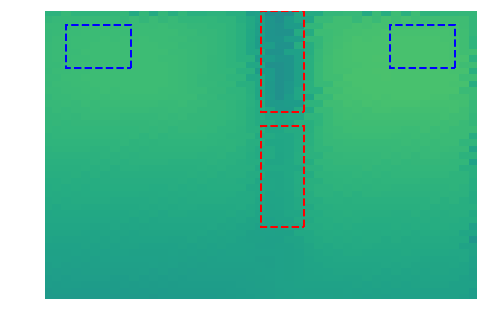

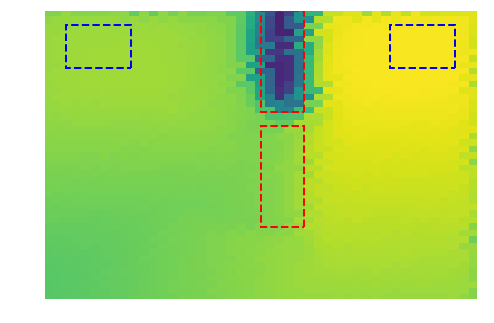

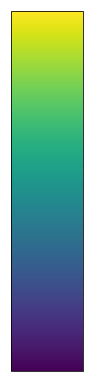

In [9]:
# figure 1
x_edge = np.linspace(-11,11,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-11,11,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)
xi = xi.flatten()
yi = yi.flatten()

values = np.array([my_value( np.array([x,y]), (0,0,0,0)) for (x,y) in zip(xi, yi)])

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
ax.set_axis_off()

fig.add_axes(ax)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.pcolor(x_edge, y_edge, values.reshape((49,49)), vmin=0, vmax=1)

ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1']), facecolor='none', linestyle='--', linewidth=2, edgecolor='blue'  ))
ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2']), facecolor='none', linestyle='--', linewidth=2, edgecolor='blue'  ))

ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1']), facecolor='none', linestyle='--', linewidth=2, edgecolor='red'  ))
ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2']), facecolor='none', linestyle='--', linewidth=2, edgecolor='red'  ))

fig.savefig('value1.pdf')

# figure 2
values = np.array([my_value( np.array([x,y]), (0,1,0,1)) for (x,y) in zip(xi, yi)])

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
ax.set_axis_off()

fig.add_axes(ax)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.pcolor(x_edge, y_edge, values.reshape((49,49)), vmin=0, vmax=1)

ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1']), facecolor='none', linestyle='--', linewidth=2, edgecolor='blue'  ))
ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2']), facecolor='none', linestyle='--', linewidth=2, edgecolor='blue'  ))

ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1']), facecolor='none', linestyle='--', linewidth=2, edgecolor='red'  ))
ax.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2']), facecolor='none', linestyle='--', linewidth=2, edgecolor='red'  ))

fig.savefig('value2.pdf')

fig = plt.figure(figsize=(1,5))
ax = plt.Axes(fig, [0.,0.,1.,1.])
ax.set_axis_off()

fig.add_axes(ax)

cb1 = matplotlib.colorbar.ColorbarBase(ax)

fig.savefig('cbar.pdf')

### Run simulation 1

reached
reached
reached
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


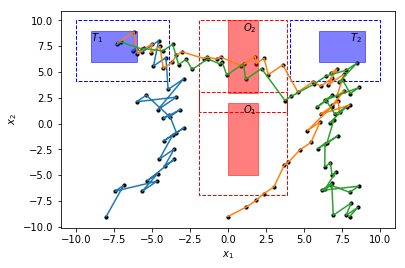

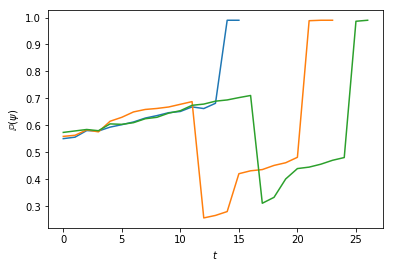

In [10]:
from matplotlib2tikz import save as tikz_save
import scipy.linalg as scla
import matplotlib

np.random.seed(10)

time = 90
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)

# plot regions
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1']), color='red', alpha=0.5 ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2']), color='red', alpha=0.5 ))
ax1.text(1, 1, '$O_1$')
ax1.text(1, 9, '$O_2$')

ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1meas']), facecolor='none', linestyle='--', edgecolor='red' ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2meas']), facecolor='none', linestyle='--', edgecolor='red' ))


ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1']), color='blue', alpha=0.5 ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2']), color='blue', alpha=0.5 ))
ax1.text(-9, 8, '$T_1$')
ax1.text(8, 8, '$T_2$')

ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1meas']), facecolor='none', linestyle='--', edgecolor='blue' ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2meas']), facecolor='none', linestyle='--', edgecolor='blue' ))


realmap = [1, 2, 1, 2]   # true map state

Wsqrt = scla.sqrtm(sys_lti.W)
for xinit in range(-8, 9, 8):
    pol.reset()
    mapstate = [0, 0, 0, 0]
    xx = np.array([[xinit],[-9]])
    vv = np.array([my_value(xx, mapstate)])

    for t in range(time): 
        # current state
        xt = xx[:,-1].reshape(2,1)
        # reveal map if within distance
        if regions['target1meas'].contains(xt):
            mapstate[0] = realmap[0]
        if regions['target2meas'].contains(xt):
            mapstate[1] = realmap[1]
        if regions['obstacle1meas'].contains(xt):
            mapstate[2] = realmap[2]
        if regions['obstacle2meas'].contains(xt):
            mapstate[3] = realmap[3]
            
        # next state
        ut, vt = my_policy(xt, mapstate)

        if pol.finished() :
            print('reached')
            break
            
        # update state
        xt1, P1 = belief_mdp.simulate(ut, xt)

        xx = np.hstack([xx, xt1])
        vv = np.hstack([vv, vt])

    if not pol.finished():
        print('not reached')

    ax1.plot(xx[0,:],xx[1,:])
    ax1.scatter(xx[0,:],xx[1,:], color='k', s=10, marker="o")
    
    ax2.plot(range(t+1), vv)

ax1.set_xlabel('$x_1$') 
ax1.set_ylabel('$x_2$') 

ax2.set_xlabel('$t$')
ax2.set_ylabel('$\\mathbb{P}(\\psi)$')

tikz_save('exp1-map.tikz', figure=fig1, figurewidth='\\figurewidth', figureheight='\\figureheight')
tikz_save('exp1-prob.tikz', figure=fig2, figurewidth='\\figurewidth', figureheight='\\figureheight')

### Run simulation 2

reached
reached
reached
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


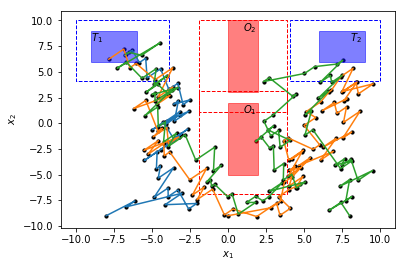

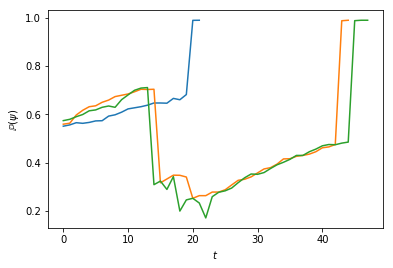

In [11]:
np.random.seed(2)

time = 90
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)

# plot regions
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1']), color='red', alpha=0.5 ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2']), color='red', alpha=0.5 ))
ax1.text(1, 1, '$O_1$')
ax1.text(1, 9, '$O_2$')

ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle1meas']), facecolor='none', linestyle='--', edgecolor='red' ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['obstacle2meas']), facecolor='none', linestyle='--', edgecolor='red' ))


ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1']), color='blue', alpha=0.5 ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2']), color='blue', alpha=0.5 ))
ax1.text(-9, 8, '$T_1$')
ax1.text(8, 8, '$T_2$')

ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target1meas']), facecolor='none', linestyle='--', edgecolor='blue' ))
ax1.add_patch(matplotlib.patches.Polygon( pc.extreme(regions['target2meas']), facecolor='none', linestyle='--', edgecolor='blue' ))


realmap = [1, 2, 1, 1]   # true map state

Wsqrt = scla.sqrtm(sys_lti.W)
for xinit in range(-8, 9, 8):
    pol.reset()
    mapstate = [0, 0, 0, 0]
    xx = np.array([[xinit],[-9]])
    vv = np.array([my_value(xx, mapstate)])

    for t in range(time): 
        # current state
        xt = xx[:,-1].reshape(2,1)
        
        # reveal map if within distance
        if regions['target1meas'].contains(xt):
            mapstate[0] = realmap[0]
        if regions['target2meas'].contains(xt):
            mapstate[1] = realmap[1]
        if regions['obstacle1meas'].contains(xt):
            mapstate[2] = realmap[2]
        if regions['obstacle2meas'].contains(xt):
            mapstate[3] = realmap[3]
        
        # next state
        ut, vt = my_policy(xt, mapstate)

        if pol.finished():
            print('reached')
            break
            
        # update state
        xt1, P1 = belief_mdp.simulate(ut, xt)

        xx = np.hstack([xx, xt1])
        vv = np.hstack([vv, vt])

    if not pol.finished():
        print('not reached')

    ax1.plot(xx[0,:],xx[1,:])
    ax1.scatter(xx[0,:],xx[1,:], color='k', s=10, marker="o")
    
    ax2.plot(range(t+1), vv)

ax1.set_xlabel('$x_1$') 
ax1.set_ylabel('$x_2$') 

ax2.set_xlabel('$t$')
ax2.set_ylabel('$\\mathbb{P}(\\psi)$')

tikz_save('exp2-map.tikz', figure=fig1, figurewidth='\\figurewidth', figureheight='\\figureheight')
tikz_save('exp2-prob.tikz', figure=fig2, figurewidth='\\figurewidth', figureheight='\\figureheight')